In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.random.set_seed(1234)

In [3]:
def get_stock_data(year):
    data = pd.read_csv('./data/nvda.csv')
    data = data[data['Date'].str.contains(str(year))]
    data = data[::-1]
    return data['Open'].map(lambda x: float(x[1:])).values

In [4]:
data_train = get_stock_data(2024)
data_test = get_stock_data(2025)
data_all = np.concatenate([data_train, data_test])

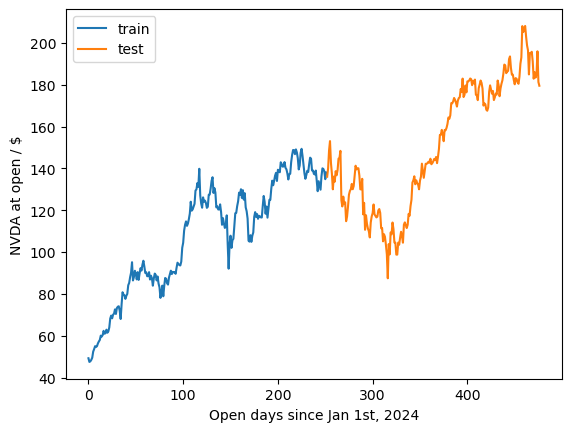

In [5]:
plt.plot(data_train, label="train")
plt.plot(
    np.arange(data_train.size, data_all.size),
    data_test,
    label="test",
)
plt.legend()
plt.xlabel('Open days since Jan 1st, 2024')
plt.ylabel('NVDA at open / $');

In [6]:
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train.reshape(-1, 1))
data_test_scaled = scaler.transform(data_test.reshape(-1, 1))
data_all_scaled = np.concatenate([data_train_scaled, data_test_scaled])

In [7]:
def get_X_y(data, n_train=50, rescale=False):
    X = np.empty((data.size-n_train, n_train, 1))
    y = np.empty(data.size-n_train)
    for i in range(0, data.size-n_train):
        X[i] = data[i:i+n_train]
        y[i] = data[i+n_train][0]
    if rescale:
        X_min = np.empty(data.size-n_train)
        for i in range(0, data.size-n_train):
            X_min[i] = X[i].min()
            X[i] -= X_min[i]
            y[i] -= X_min[i]
        return X, y, X_min
    return X, y

In [8]:
X, y, X_min = get_X_y(data_all_scaled, n_train=50, rescale=True)
X.shape, y.shape, X_min.shape

((427, 50, 1), (427,), (427,))

In [9]:
n_train = 50
X_train, X_test = np.array_split(X, [data_train.size-n_train])
y_train, y_test = np.array_split(y, [data_train.size-n_train])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((202, 50, 1), (225, 50, 1), (202,), (225,))

In [10]:
def get_model(n):
    model = keras.models.Sequential([
        keras.layers.Input(shape=X_train.shape[1:]),
        keras.layers.LSTM(n),
        keras.layers.Dense(1)
    ])
    return model

In [11]:
model = get_model(n=50)

In [12]:
model.compile(
    optimizer='adam', 
    loss='mean_squared_error',
)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2,
    # callbacks=[keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     restore_best_weights=True,
    # )],
    verbose=0,
)

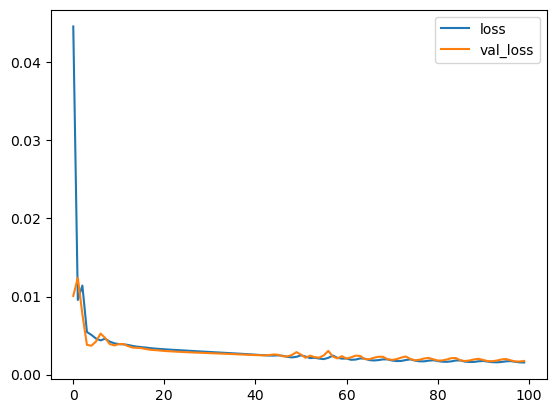

In [14]:
for metric in history.history.keys():
    plt.plot(history.history[metric], label=metric)
plt.legend();

In [15]:
y_pred = model.predict(X_test, verbose=0)
data_pred = scaler.inverse_transform(y_pred+X_min[data_train.size-n_train:,None]).squeeze()

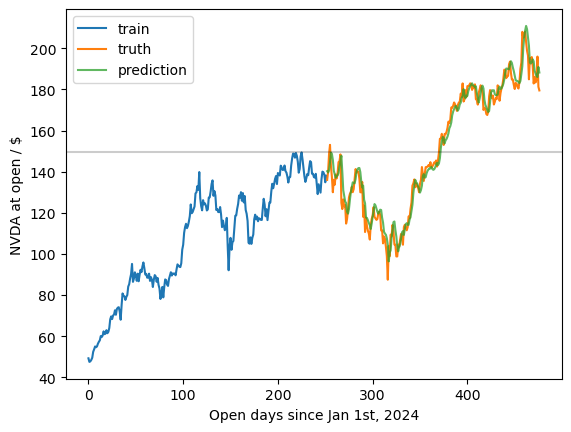

In [16]:
plt.plot(data_train, label="train")
plt.plot(
    np.arange(data_train.size, data_all.size),
    data_test,
    label="truth",
)
plt.plot(
    np.arange(data_train.size, data_all.size),
    data_pred,
    alpha=0.75,
    label="prediction",
)
plt.axhline(data_train.max(), c='k', alpha=0.2)
plt.legend()
plt.xlabel('Open days since Jan 1st, 2024')
plt.ylabel('NVDA at open / $');

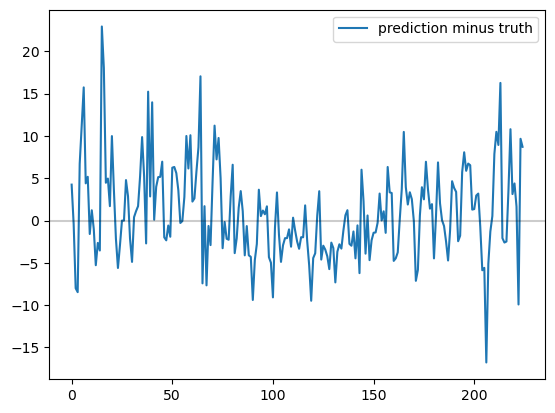

In [17]:
plt.plot(
    data_pred-data_test,
    label="prediction minus truth",
)
plt.axhline(0, c='k', alpha=0.2)
plt.legend();